In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import os
import multiprocessing
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, f1_score, accuracy_score

base_path = "/Users/bengieru/Library/Mobile Documents/com~apple~CloudDocs/professional/code/MLN/Results/general_diagnostics_01/"

import sys
sys.path.insert(0, base_path)

from helpers import *
from Temporal_Community_Detection import temporal_network

/Users/bengieru/Library/Mobile Documents/com~apple~CloudDocs/professional/code/MLN/Results/general_diagnostics_01/Temporal_Community_Detection.py:29: UserWarning: Graph-tool requires its own environment. Restart the kernel with a gt environment to run DSBM, otherwise you can proceed.
  warnings.warn(message = 'Graph-tool requires its own environment. Restart the kernel with a gt environment to run DSBM, otherwise you can proceed.')


In [2]:
fixed_size = int(abs(np.random.normal(30,10)))
spike_rate = int(abs(np.random.normal(20,8)))# spike rate per commiunity
layers = 6
num_neurons = layers*fixed_size

comm_sizes = [fixed_size for i in range(layers)] 

spike_rates = [int(abs(np.random.normal(20,8))) for i in range(layers)]

window_size = 1000 # size, in frames, each adjacency matrix correspond to. better to be equal to bin_size 
standard_dev = 1.2 # for gaussian kernel
k = 5 #for jittering the spikes
pad = True

spikes = create_time_series('grow', comm_sizes, spike_rates, windowsize = window_size, k = k, spy = False)

num_neurons = sum(comm_sizes)

binned_spikes = bin_time_series(spikes, window_size, gaussian = True, sigma = standard_dev)

adjacency_matrices = []
for i in range(layers):
    adjacency_matrices.append(cross_correlation_matrix(binned_spikes[i])[0])

/Users/bengieru/Library/Mobile Documents/com~apple~CloudDocs/professional/code/MLN/Results/general_diagnostics_01/helpers.py:33: RuntimeWarning: invalid value encountered in sqrt
  x_cov_std = np.nanmax(np.sqrt(np.correlate(x - x_mean, x - x_mean, 'full')))
/Users/bengieru/Library/Mobile Documents/com~apple~CloudDocs/professional/code/MLN/Results/general_diagnostics_01/helpers.py:34: RuntimeWarning: invalid value encountered in sqrt
  y_cov_std = np.nanmax(np.sqrt(np.correlate(y - y_mean, y - y_mean, 'full')))


In [3]:
TN = temporal_network(num_neurons, layers, window_size, 
                      data = 'list__adjacency', 
                      list_adjacency = adjacency_matrices, 
                      omega = 1, kind = 'ordinal')

In [4]:
interlayers = np.linspace(0, 1, 6)
resolutions = np.linspace(0.9, 1.1, 6)

In [5]:
pred_partitions, C = TN.run_community_detection(method = 'MMM', ## modularity maximization
                                                update_method = 'skeleton', ## skeleton coupling
                                                interlayers = interlayers, #gridsearch parameters1
                                                resolutions = resolutions, #gridsearch parameters2
                                                spikes = spikes) # Spike train

In [39]:
NMI_mmm = np.zeros((len(interlayers), len(resolutions)))
ARI_mmm = np.zeros((len(interlayers), len(resolutions)))
ACC_mmm = np.zeros((len(interlayers), len(resolutions)))
F1S_mmm = np.zeros((len(interlayers), len(resolutions)))

true_labels = generate_ground_truth(comm_sizes, community_operation = 'grow')

for i, e in enumerate(interlayers):
    for j, f in enumerate(resolutions):
        NMI_mmm[i][j] = normalized_mutual_info_score(true_labels, list(C[i*len(resolutions)+j].astype(int)), average_method = 'max')
        ARI_mmm[i][j] = adjusted_rand_score(true_labels, list(C[i*len(resolutions)+j].astype(int)))
        F1S_mmm[i][j] = f1_score(true_labels, list(C[i*len(resolutions)+j].astype(int)), average = 'weighted')
        ACC_mmm[i][j] = accuracy_score(true_labels, list(C[i*len(resolutions)+j].astype(int)), normalize = True)

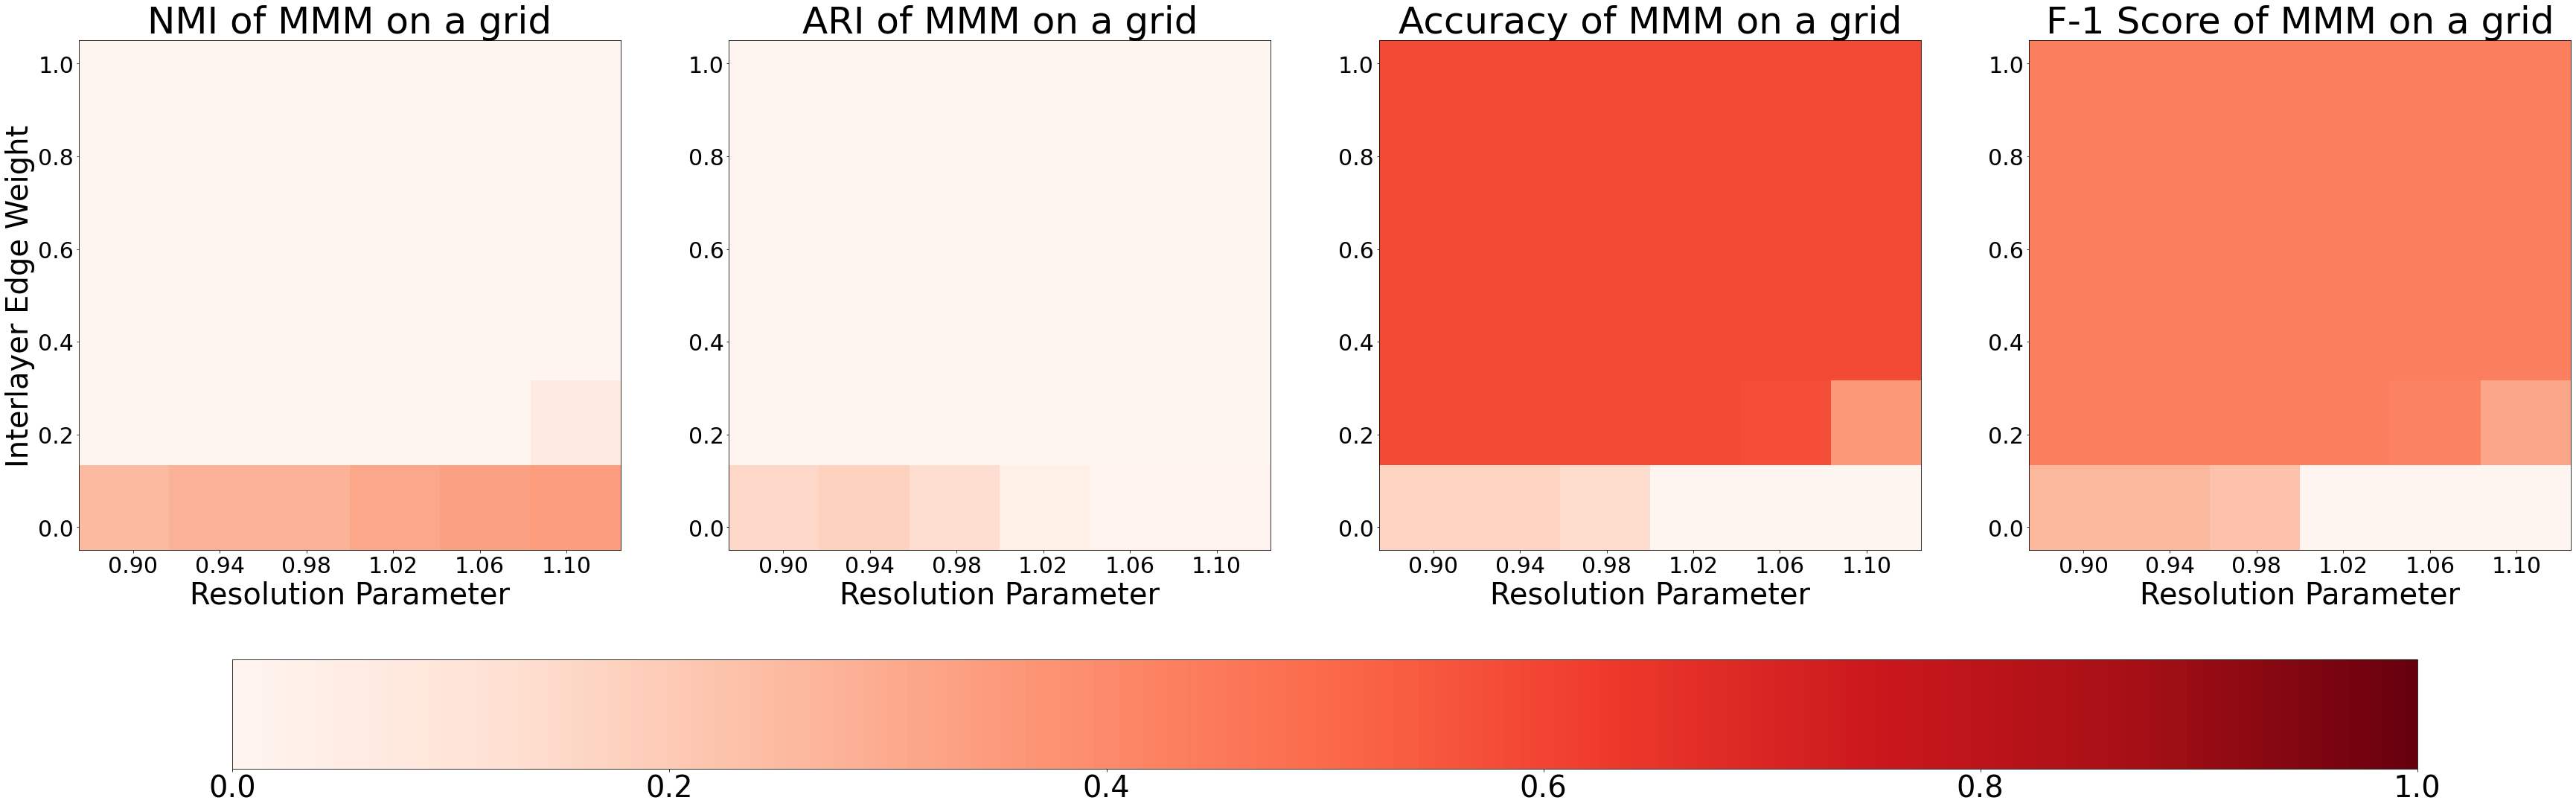

In [40]:
fig,ax = plt.subplots(1,4, figsize = (60, 18))
normalize = Normalize(vmin = 0, vmax = 1)

metrics = ['NMI', 'ARI', 'Accuracy', 'F-1 Score']
scores = [NMI_mmm, ARI_mmm, ACC_mmm, F1S_mmm]
for i in range(4):
    c = ax[i].imshow(scores[i], origin = 'lower', interpolation = 'none', cmap = 'Reds', aspect = 'auto', norm = normalize, 
                     extent = [resolutions[0]-0.025, resolutions[-1]+0.025, interlayers[0]-0.05, interlayers[-1]+0.05])
    ax[i].set_title('%s of MMM on a grid'%metrics[i], fontsize = 50)
    ax[i].set_xlabel('Resolution Parameter', fontsize = 40)
    ax[i].set_xticks(resolutions)
    ax[i].set_yticks(interlayers)
    ax[i].tick_params(axis = 'both', labelsize = 30)
    
ax[0].set_ylabel('Interlayer Edge Weight', fontsize = 40)

cbar = fig.colorbar(c, ax = ax.flat, orientation = 'horizontal')
cbar.ax.tick_params(labelsize = 40)